# **Task 1 - Student Score Prediction**
- To build a regression model that predicts students’ exam scores based on study hours.
- To analyze the relationship between study time and performance.
- To compare simple linear regression with polynomial regression for improved accuracy.

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [8]:
# Define RMSE function (compatible with all sklearn versions)
try:
    from sklearn.metrics import root_mean_squared_error
    def rmse_func(y_true, y_pred):
        return root_mean_squared_error(y_true, y_pred)
except ImportError:
    from sklearn.metrics import mean_squared_error
    def rmse_func(y_true, y_pred):
        return mean_squared_error(y_true, y_pred, squared=False)


#### Data Loading 

In [9]:
#Data Loading 
DATA_PATH = "StudentPerformanceFactors.csv"  
df = pd.read_csv(DATA_PATH)

#### Exploratory data analysis (EDA)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6607 non-null   int64 
 1   Attendance                  6607 non-null   int64 
 2   Parental_Involvement        6607 non-null   object
 3   Access_to_Resources         6607 non-null   object
 4   Extracurricular_Activities  6607 non-null   object
 5   Sleep_Hours                 6607 non-null   int64 
 6   Previous_Scores             6607 non-null   int64 
 7   Motivation_Level            6607 non-null   object
 8   Internet_Access             6607 non-null   object
 9   Tutoring_Sessions           6607 non-null   int64 
 10  Family_Income               6607 non-null   object
 11  Teacher_Quality             6529 non-null   object
 12  School_Type                 6607 non-null   object
 13  Peer_Influence              6607 non-null   obje

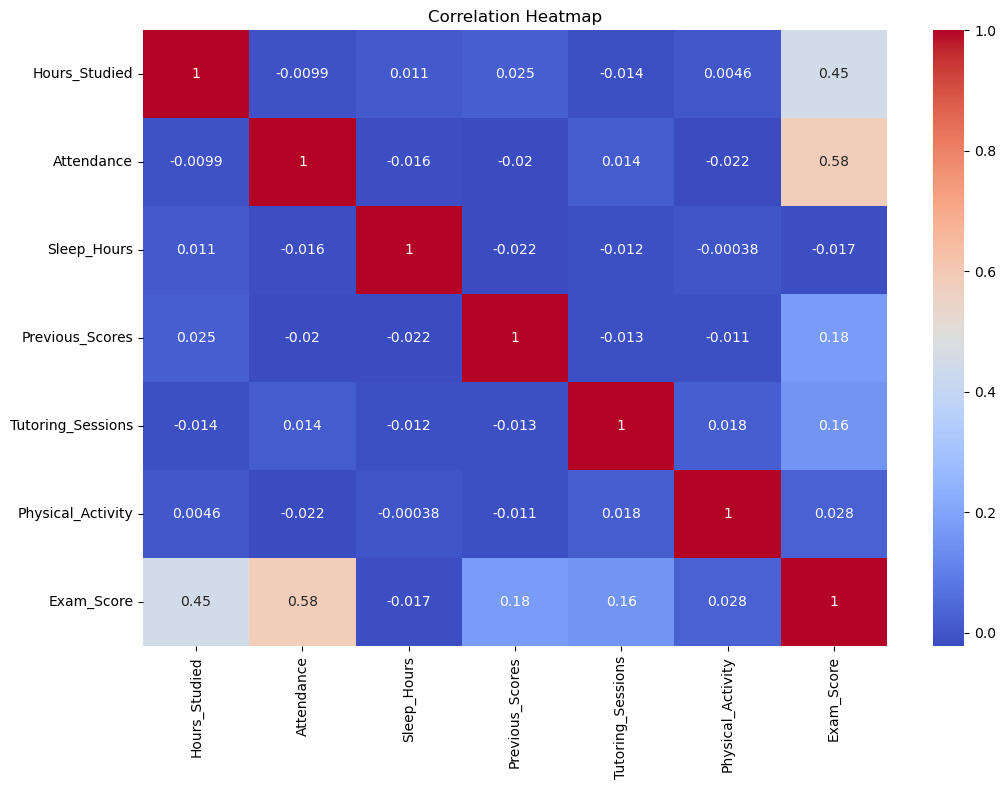

In [10]:
# Basic dataset info
print(df.info())
print(df.describe())

# Check for missing values
print(df.isnull().sum())

# Correlation heatmap (for numerical features)
import seaborn as sns
plt.figure(figsize=(12, 8))
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Study hours vs score visualization (if 'study_hours' column exists)
if 'study_hours' in df.columns:
    plt.figure()
    plt.scatter(df['study_hours'], df[TARGET])
    plt.xlabel('Study Hours')
    plt.ylabel('Exam Score')
    plt.title('Study Hours vs Exam Score')
    plt.show()

#### Data Cleaning 

In [11]:
# Data Cleaning 
df.columns = df.columns.str.strip()
df = df.drop_duplicates()

In [12]:
# Try common target names; raise if not found
possible_targets = [
    "Exam_Score", "Exam Score", "exam_score", "Final_Grade", "final_grade",
    "final_score", "Score", "Final Score", "G3", "Overall_Grade"
]
found_targets = [c for c in possible_targets if c in df.columns]
if not found_targets:
    raise ValueError("Target column not found. Rename your exam/score column to one of: " + ", ".join(possible_targets))
TARGET = found_targets[0]

In [13]:
# Drop obviously ID-like columns if present
id_like = [c for c in df.columns if c.lower() in {"id","studentid","student_id","index"}]
df = df.drop(columns=id_like, errors='ignore')

#### Feature/Target Split 

In [14]:

X = df.drop(columns=[TARGET])
y = df[TARGET].astype(float)

In [15]:
# Identify types
num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X.select_dtypes(exclude=["number"]).columns.tolist()


#### Data Preprocess (Impute + Encode + Scale) 

In [16]:

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

pre = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])


#### Train/Test Split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### **Model : Linear Regression**

In [18]:
# Model: Linear Regression
lin_model = Pipeline([
    ("pre", pre),
    ("lin", LinearRegression())
])
lin_model.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Hours_Studied',
                                                   'Attendance', 'Sleep_Hours',
                                                   'Previous_Scores',
                                                   'Tutoring_Sessions',
                                                   'Physical_Activity']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Parental_Involvement',
                                                   'Access_to_Resources',
                                                   'Extracurricular_Activities',
                                                   'Motivation_Level',
                                                   'Internet_Access',
                                                   'Family_Income',
                                                   'Teacher_Quality',
                                                   'School_Type',
                                                   'Peer_Influence',
                                                   'Learning_Disabilities',
                                                   'Parental_Education_Level',
                                                   'Distance_from_Home',
                                                   'Gender'])])),
                ('lin', LinearRegression())])

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
#  Evaluation 
pred = lin_model.predict(X_test)
mae = mean_absolute_error(y_test, pred)
rmse = root_mean_squared_error(y_test, pred)   # new function
r2 = r2_score(y_test, pred)

print({"MAE": round(mae,3), "RMSE": round(rmse,3), "R2": round(r2,3)})


{'MAE': 0.452, 'RMSE': 1.804, 'R2': 0.77}


#### Visualization

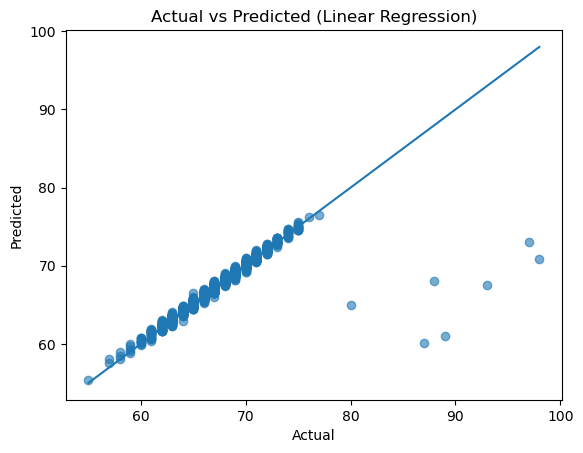

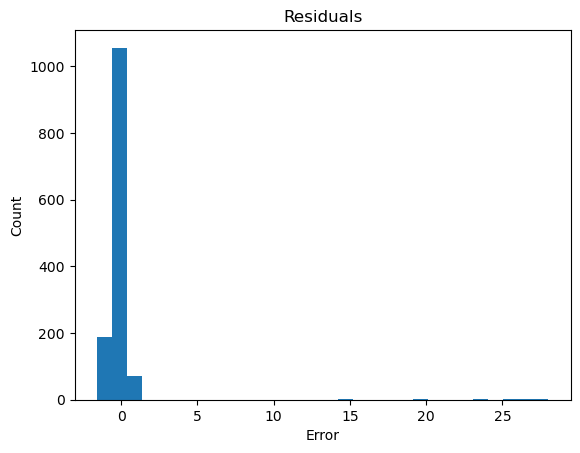

In [20]:
plt.figure()
plt.scatter(y_test, pred, alpha=0.6)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted (Linear Regression)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()])
plt.show()

plt.figure()
res = y_test - pred
plt.hist(res, bins=30)
plt.title("Residuals")
plt.xlabel("Error")
plt.ylabel("Count")
plt.show()

### **(Bonus) Polynomial Regression  comparison**

In [21]:
# ===== (Bonus) Polynomial Regression (quick compare) =====
poly_model = Pipeline([
("pre", pre),
("poly", PolynomialFeatures(degree=2, include_bias=False)),
("lin", LinearRegression())
])
poly_model.fit(X_train, y_train)
pp = poly_model.predict(X_test)
print({
"Poly(deg=2)_MAE": round(mean_absolute_error(y_test, pp),3),
"Poly(deg=2)_RMSE": round(rmse_func(y_test, pp),3),
"Poly(deg=2)_R2": round(r2_score(y_test, pp),3)
})

{'Poly(deg=2)_MAE': 0.656, 'Poly(deg=2)_RMSE': 1.895, 'Poly(deg=2)_R2': 0.746}


#### Experiment with different feature combinations

In [26]:
# Try different feature combinations
# Example: Remove sleep-related features if they exist
features_to_remove = [col for col in X.columns if 'sleep' in col.lower()]
print(f"Features to remove: {features_to_remove}")

X_reduced = X.drop(columns=features_to_remove)

# Retrain and compare
X_train_red, X_test_red, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.2, random_state=42
)

# Identify new column types for the reduced dataset
num_cols_red = X_reduced.select_dtypes(include=["number"]).columns.tolist()
cat_cols_red = X_reduced.select_dtypes(exclude=["number"]).columns.tolist()

print(f"Numerical columns after removal: {num_cols_red}")
print(f"Categorical columns after removal: {cat_cols_red}")

# Create the same preprocessing pipeline but for reduced features
num_pipe_red = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipe_red = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

pre_red = ColumnTransformer([
    ("num", num_pipe_red, num_cols_red),
    ("cat", cat_pipe_red, cat_cols_red)
])

# Train model with reduced features
lin_model_red = Pipeline([
    ("pre", pre_red),
    ("lin", LinearRegression())
])

lin_model_red.fit(X_train_red, y_train)

# Evaluate the reduced model
pred_red = lin_model_red.predict(X_test_red)
mae_red = mean_absolute_error(y_test, pred_red)
rmse_red = rmse_func(y_test, pred_red)
r2_red = r2_score(y_test, pred_red)

print("\n=== COMPARISON RESULTS ===")
print("ORIGINAL MODEL (all features):")
print({"MAE": round(mae, 3), "RMSE": round(rmse, 3), "R2": round(r2, 3)})

print("\nREDUCED MODEL (no sleep-related features):")
print({"MAE": round(mae_red, 3), "RMSE": round(rmse_red, 3), "R2": round(r2_red, 3)})

# Calculate the difference
mae_diff = mae_red - mae
rmse_diff = rmse_red - rmse
r2_diff = r2_red - r2

print("\nDIFFERENCE (Reduced - Original):")
print({"MAE_Diff": round(mae_diff, 3), 
       "RMSE_Diff": round(rmse_diff, 3), 
       "R2_Diff": round(r2_diff, 3)})

# Interpretation
if mae_diff > 0:
    print("\n Removing sleep features made predictions WORSE (higher error)")
elif mae_diff < 0:
    print("Removing sleep features made predictions BETTER (lower error)")
else:
    print("Removing sleep features made NO DIFFERENCE in predictions")

Features to remove: ['Sleep_Hours']
Numerical columns after removal: ['Hours_Studied', 'Attendance', 'Previous_Scores', 'Tutoring_Sessions', 'Physical_Activity']
Categorical columns after removal: ['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities', 'Motivation_Level', 'Internet_Access', 'Family_Income', 'Teacher_Quality', 'School_Type', 'Peer_Influence', 'Learning_Disabilities', 'Parental_Education_Level', 'Distance_from_Home', 'Gender']

=== COMPARISON RESULTS ===
ORIGINAL MODEL (all features):
{'MAE': 0.452, 'RMSE': 1.804, 'R2': 0.77}

REDUCED MODEL (no sleep-related features):
{'MAE': 0.454, 'RMSE': 1.805, 'R2': 0.77}

DIFFERENCE (Reduced - Original):
{'MAE_Diff': 0.002, 'RMSE_Diff': 0.0, 'R2_Diff': -0.0}

 Removing sleep features made predictions WORSE (higher error)
